<a href="https://colab.research.google.com/github/BenShieh233/Learn_Python/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
!pip install -q pyomo
from pyomo.environ import *
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

     |████████████████████████████████| 11.1 MB 25.7 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 


In [2]:
from pyomo.opt.results import default_print_options
from IPython.utils.io import raw_print

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Find the index's components

In [4]:
df_components = pd.read_csv('/content/IDX_Smprat.csv')
df_components['indexcd'] = df_components['Indexcd'].astype(str).str.rjust(6, fillchar = '0')
df_components['stkcd'] = df_components['Stkcd'].astype(str).str.rjust(6, fillchar = '0')
df_components = df_components.loc[(df_components['indexcd']=='000300') & (df_components['Enddt']=='2022-12-16')]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# collect all the components of the index
stk_list =df_components.stkcd.tolist() 

# Import the components' monthly return data

In [6]:
df_stk = pd.read_csv('/content/TRD_Mnth.csv')
df_stk['stkcd'] = df_stk['Stkcd'].astype(str).str.rjust(6, fillchar = '0')
df_stk = df_stk[df_stk['Trdmnt']>='2020-12'] # Use the data in 24 months

In [7]:
# Keep the stocks with full monthly data
stk_list1 = []
for stock in stk_list:
  length = len(df_stk[df_stk['stkcd']== str(stock)]['Trdmnt'])
  if length == 24:
    stk_list1.append(str(stock))
df_stk = df_stk[df_stk['stkcd'].isin(stk_list1)].reset_index()

In [8]:
df_stk = df_stk.drop(columns=['index', 'Stkcd','Msmvttl','Mretnd'])

In [9]:
df_stk

,Trdmnt,Msmvosd,Mretwd,stkcd
0,2020-12,3.753073e+08,-0.020263,000001
1,2021-01,4.480789e+08,0.193899,000001
2,2021-02,4.148950e+08,-0.074058,000001
3,2021-03,4.271207e+08,0.029467,000001
4,2021-04,4.519600e+08,0.058155,000001
...,...,...,...,...
6907,2022-07,7.771298e+07,-0.112464,688981
6908,2022-08,7.794560e+07,0.002993,688981
6909,2022-09,7.395067e+07,-0.060433,688981
6910,2022-10,8.164327e+07,0.104023,688981


# Import the stocks' market valuation metrics data

In [10]:
df1 = pd.read_csv('/content/STK_MKT_ValuationMetrics.csv')
df2 = pd.read_csv('/content/STK_MKT_ValuationMetrics1.csv')
df3 = pd.read_csv('/content/STK_MKT_ValuationMetrics2.csv')

In [11]:
df1['stkcd'] = df1['Symbol'].astype(str).str.rjust(6, fillchar = '0')
df2['stkcd'] = df2['Symbol'].astype(str).str.rjust(6, fillchar = '0')
df3['stkcd'] = df3['Symbol'].astype(str).str.rjust(6, fillchar = '0')

In [12]:
df_metrics = pd.concat([df1, df2, df3], axis = 0)
df_metrics = df_metrics[df_metrics['stkcd'].isin(stk_list1)]

In [13]:
# Convert the trading date column to date format
df_metrics.index = pd.to_datetime(df_metrics['TradingDate'])

In [14]:
# Calculate the monthly PB ratio grouped by stock id, year, and month, using simple average
df_PBA = df_metrics.groupby([df_metrics.stkcd, df_metrics.index.year, df_metrics.index.month], as_index = False).apply(lambda x: x.PBV1A.mean())

In [15]:
df_PBA = df_PBA.rename(columns={None:'PBA'})

In [16]:
# Calculate the book-to-market ratio (inverse of price-to-book ratio)
df_final = pd.concat([df_stk, df_PBA], axis = 1)
df_final['BM'] = df_final['PBA']**(-1)
df_final = df_final[['stkcd', 'Trdmnt', 'Mretwd', 'Msmvosd', 'BM']]
df_final = df_final.iloc[:,1:]
df_final

,stkcd,Trdmnt,Mretwd,Msmvosd,BM
0,000001,2020-12,-0.020263,3.753073e+08,0.856695
1,000001,2021-01,0.193899,4.480789e+08,0.886923
2,000001,2021-02,-0.074058,4.148950e+08,0.793904
3,000001,2021-03,0.029467,4.271207e+08,0.873164
4,000001,2021-04,0.058155,4.519600e+08,0.856515
...,...,...,...,...,...
6907,688981,2022-07,-0.112464,7.771298e+07,0.486594
6908,688981,2022-08,0.002993,7.794560e+07,0.494958
6909,688981,2022-09,-0.060433,7.395067e+07,0.521565
6910,688981,2022-10,0.104023,8.164327e+07,0.532512


# Divide the stocks into H, M, and L groups in terms of the quantiles according to the book-to-market ratio (3:4:3).

In [17]:
# Split the stocks based on the book-to-market ratio (BM) by month.
# Sort the stocks by its montly book-to-market ratio in an descending order.
# If BM <= 30%, label the stock as "L(low)"
# If 30% < BM <= 70%, label the stock as "M(medium)"
# If BM > 70%, label the stock as "L(large)"

In [18]:
# Define the splitting function
def split_BM(x):
  x.loc[x['BM']>=x.BM.quantile(0.7), 'HML'] = 'H'
  x.loc[x['BM']<x.BM.quantile(0.3), 'HML'] = 'L'
  return x

df_final['HML'] = 'M'
df_final = df_final.groupby(['Trdmnt']).apply(split_BM)

# Split the stocks in to B and S groups in terms of the median of montly market values

In [19]:
# Split the stocks based on market values (MV) by month.
# In each month, 
# If MV > median(MV), label the stock as "B(big)"
# If MV <= median(MV), label the stock as "S(small)"

In [20]:
# Define the splitting function
def split_SB(x):
  x.loc[x['Msmvosd']<=x.Msmvosd.median(), 'SB'] = 'S'
  x.loc[x['Msmvosd']>x.Msmvosd.median(), 'SB'] = 'B'
  return x

df_final['SB'] = 'B'
df_final = df_final.groupby(['Trdmnt']).apply(split_SB)

In [21]:
# Create subgroups by combining the SB and HML groups
df_final['portfolio_name'] = df_final.SB + '/' + df_final.HML
df_final

,stkcd,Trdmnt,Mretwd,Msmvosd,BM,HML,SB,portfolio_name
0,000001,2020-12,-0.020263,3.753073e+08,0.856695,H,B,B/H
1,000001,2021-01,0.193899,4.480789e+08,0.886923,H,B,B/H
2,000001,2021-02,-0.074058,4.148950e+08,0.793904,H,B,B/H
3,000001,2021-03,0.029467,4.271207e+08,0.873164,H,B,B/H
4,000001,2021-04,0.058155,4.519600e+08,0.856515,H,B,B/H
...,...,...,...,...,...,...,...,...
6907,688981,2022-07,-0.112464,7.771298e+07,0.486594,M,B,B/M
6908,688981,2022-08,0.002993,7.794560e+07,0.494958,M,B,B/M
6909,688981,2022-09,-0.060433,7.395067e+07,0.521565,M,B,B/M
6910,688981,2022-10,0.104023,8.164327e+07,0.532512,M,B,B/M


In [22]:
df_final['portfolio_name'].unique()

array(['B/H', 'B/M', 'S/H', 'S/M', 'S/L', 'B/L'], dtype=object)

In [23]:
df_final

,stkcd,Trdmnt,Mretwd,Msmvosd,BM,HML,SB,portfolio_name
0,000001,2020-12,-0.020263,3.753073e+08,0.856695,H,B,B/H
1,000001,2021-01,0.193899,4.480789e+08,0.886923,H,B,B/H
2,000001,2021-02,-0.074058,4.148950e+08,0.793904,H,B,B/H
3,000001,2021-03,0.029467,4.271207e+08,0.873164,H,B,B/H
4,000001,2021-04,0.058155,4.519600e+08,0.856515,H,B,B/H
...,...,...,...,...,...,...,...,...
6907,688981,2022-07,-0.112464,7.771298e+07,0.486594,M,B,B/M
6908,688981,2022-08,0.002993,7.794560e+07,0.494958,M,B,B/M
6909,688981,2022-09,-0.060433,7.395067e+07,0.521565,M,B,B/M
6910,688981,2022-10,0.104023,8.164327e+07,0.532512,M,B,B/M


# Calculating the portfolio's returns (six portfolios in total, S/H, S/M, S/L, B/H, B/M, and B/L)

In [24]:
# Calculate the monthly return of each portfolio.
# The monthly return of a portfolio is the market-value-weighted average of its components' returns.
# Formula: 
port_ret = df_final.groupby(['Trdmnt','portfolio_name']).apply(lambda x: (x.Mretwd*x.Msmvosd).sum()/x.Msmvosd.sum())
port_ret = port_ret.reset_index()
port_ret.columns = ['Trdmnt','portfolio_name','return']
port_ret

,Trdmnt,portfolio_name,return
0,2020-12,B/H,-0.038257
1,2020-12,B/L,0.235374
2,2020-12,B/M,0.052955
3,2020-12,S/H,-0.041945
4,2020-12,S/L,0.115321
...,...,...,...
139,2022-11,B/L,0.078334
140,2022-11,B/M,0.133177
141,2022-11,S/H,0.170487
142,2022-11,S/L,0.058831


In [25]:
# Print monthly return of the six portfolios
port_ret_pivot = port_ret.pivot(index = 'Trdmnt',columns='portfolio_name',values='return')
port_ret_pivot

portfolio_name,B/H,B/L,B/M,S/H,S/L,S/M
Trdmnt,,,,,,
2020-12,-0.038257,0.235374,0.052955,-0.041945,0.115321,0.075586
2021-01,-0.001369,0.069160,0.070887,-0.031008,0.095837,0.042920
2021-02,0.048198,-0.046562,0.012271,0.095285,-0.102726,-0.002445
2021-03,0.013957,-0.054559,-0.071473,0.017374,-0.045984,-0.052068
2021-04,-0.036314,0.091302,0.044268,-0.000204,0.140599,0.004102
2021-05,0.020804,0.085055,0.056310,0.049242,0.060716,0.053420
2021-06,-0.016655,0.045057,-0.009445,-0.019635,0.094484,0.030350
2021-07,-0.074710,-0.021576,-0.016731,-0.032214,-0.021610,0.015586
2021-08,0.063458,-0.016763,0.066913,0.155860,-0.074633,0.048795


# Construct the Fama-French Three-Factors Model

In [60]:
# Define the BM and HML factors
# SMB formula = (1/3)*(SL+SM+SH)-(1/3)*(BL+BM+BH)
# HML formula = (1/2)*(SH+BH) - (1/2)*(SL+BL)

In [43]:
# HML factor
HML = (port_ret_pivot['S/H'] + port_ret_pivot['B/H'])/2 - (port_ret_pivot['S/L'] + port_ret_pivot['B/L'])/2

# SMB factor
SMB=(port_ret_pivot['S/H'] + port_ret_pivot['S/M'] + port_ret_pivot['S/L'])/3 - (port_ret_pivot['B/H'] + port_ret_pivot['B/M'] + port_ret_pivot['B/L'])/3                                                     

In [77]:

# MKT factor
# MKT = rm - rf, where rm is the return of market portfolio and rf is the risk-free rate
df=pd.read_csv('/content/TRD_Mnth.csv')
df['stkcd'] = df['Stkcd'].astype(str).str.rjust(6, fillchar = '0')
df = df[df['Trdmnt']>='2020-12']

# The index's return, rp
df_rp= pd.read_csv('/content/沪深300指数历史数据.csv')
df_rp['收盘'] = df_rp['收盘'].str.replace(",","").astype(float)
df_rp['rp']=df_rp['收盘'].pct_change()
df_rp = df_rp.dropna()
df_rp = df_rp.reset_index()
rp = df_rp[['rp']].set_index(SMB.index)

# Market portolio's return, rm
df_rm = pd.read_csv('/content/中证全指历史数据.csv')
df_rm['收盘'] = df_rm['收盘'].str.replace(",","").astype(float)
df_rm['rm']=df_rm['收盘'].pct_change()
df_rm = df_rm.drop(index=0)
df_rm = df_rm.reset_index()
rm = df_rm[['rm']].set_index(SMB.index)

# Risk-free rate, rf
treasury = pd.read_csv("/content/中国十年期国债收益率历史数据.csv")
treasury['rf']=treasury['收盘'].pct_change()
treasury = treasury.dropna().reset_index()
rf = treasury[['rf']].set_index(SMB.index)
MKT_factor = pd.concat([rm,rf],axis=1)
MKT = MKT_factor['rm'] - MKT_factor['rf']

In [78]:
# Define excess return rp - rf
df_excess_ret = pd.concat([rp, rf], axis = 1)
df_excess_ret
excess_ret = df_excess_ret['rp'] - df_excess_ret['rf']

In [79]:
Fama_model = pd.DataFrame({'Intercept':1,'MKT':MKT,'SMB':SMB,'HML':HML})

In [80]:
Fama_model

,Intercept,MKT,SMB,HML
Trdmnt,,,,
2020-12,1,0.054943,-0.033703,-0.215449
2021-01,1,-0.008570,-0.010310,-0.098687
2021-02,1,-0.018840,-0.007931,0.146386
2021-03,1,-0.005941,0.010466,0.065937
2021-04,1,0.028989,0.015080,-0.134210
2021-05,1,0.080687,0.000403,-0.037862
2021-06,1,0.007172,0.028748,-0.087915
2021-07,1,0.042821,0.024926,-0.031869
2021-08,1,0.024238,0.005472,0.155357


# Regression and obtaining the alpha

In [83]:
# Calculate the alpha 
y = excess_ret.values
x = Fama_model.values.tolist()
model = sm.OLS(y, x)
results =  model.fit()
print(results.params)

[-0.01284038  0.9661365  -0.82923946 -0.04890109]


In [84]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     70.99
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           7.73e-11
Time:                        22:40:53   Log-Likelihood:                 67.722
No. Observations:                  24   AIC:                            -127.4
Df Residuals:                      20   BIC:                            -122.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0128      0.003     -3.732      0.001      -0.020      -0.006
x1             0.9661      0.078     12.422      0.000       0.804       1.128
x2            -0.8292      0.165     -5.029      0.000      -1.173      -0.485
x3            -0.0489      0.040     -1.228      0.234      -0.132       0.034
==============================================================================
Omnibus:                        2.130   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                0.889
Skew:                          -0.400   Prob(JB):                        0.641
Kurtosis:                       3.498   Cond. No.                         53.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
alpha_1 = results.params[0]
MKT_1 = results.params[1]
SMB_1 = results.params[2]
HML_1 = results.params[3]

# Optimization

In [86]:
import sympy
from sympy import Matrix

In [107]:
N = len(rm) # Sample size
f1 = sympy.Symbol('f1')
f2 = sympy.Symbol('f2')
f3 = sympy.Symbol('f3')
MKT_ad = MKT - np.ones(N)*f1
SMB_ad = SMB - np.ones(N)*f2
HML_ad = HML - np.ones(N)*f3

X = Matrix([np.ones(N), MKT_ad, SMB_ad,HML_ad])
X = X.T 
betas = Matrix([alpha_1,MKT_1,SMB_1,HML_1]) 
betas =betas.T 
XTX = sympy.simplify(X.T*X)
XTX_inv = XTX**(-1)
XTX_inv

Matrix([
[(-1.68527023990287e-55*f1**4*f2**2 + 6.17932421297721e-55*f1**4*f2*f3 - 1.18097902958542e-40*f1**4*f2 - 2.99603598204956e-55*f1**4*f3**2 - 3.56589537835956e-41*f1**4*f3 + 3.65130271333657e-26*f1**4 + 1.87550743455365e-40*f1**3*f2**2 - 2.82724755891386e-40*f1**3*f2*f3 - 6.06194133643946e-26*f1**3*f2 + 1.59252354849184e-40*f1**3*f3**2 + 2.40430850784004e-26*f1**3*f3 - 9.70413170686086e-12*f1**3 - 1.92856249232509e-40*f1**2*f2**3 + 5.92854395788823e-40*f1**2*f2**2*f3 - 3.57890891754381e-27*f1**2*f2**2 - 6.85711108382253e-40*f1**2*f2*f3**2 - 3.9046673506944e-26*f1**2*f2*f3 + 7.00092917827226e-11*f1**2*f2 - 2.0220744626997e-27*f1**2*f3**2 - 2.73217168704078e-12*f1**2*f3 - 1166.3258677584*f1**2 + 1.63370561838293e-25*f1*f2**3 - 1.0522850511431e-25*f1*f2**2*f3 - 1.53469344575945e-10*f1*f2**2 + 1.82242652308559e-25*f1*f2*f3**2 + 2.31100017534132e-11*f1*f2*f3 + 2938.93909243462*f1*f2 - 5.08695541138283e-12*f1*f3**2 - 465.275991148755*f1*f3 + 21.9419078118659*f1 - 1.3078384432407e-25*f

In [114]:
XTX_inv = XTX_inv.evalf(subs={f1:0,f2:0,f3:0})
y = Matrix(excess_ret)
errors = y-X*betas.T
var_i = sympy.simplify(1/(N-4)*errors.T*errors)
std_error_alpha = var_i[0,0]*XTX_inv[0,0]
y_bar = np.mean(excess_ret.values)
MKT_bar = np.mean(MKT)
SMB_bar = np.mean(SMB)
HML_bar = np.mean(HML)
tstats = abs(y_bar-MKT_1*(MKT_bar-f1) - SMB_1*(SMB_bar-f2) - HML_1*(HML_bar-f3))*std_error_alpha**(-0.5)
tstats = sympy.simplify(tstats)
tstats

3.30545004335944*(0.582543731844259*f1**2 - f1*f2 - 0.058971009140428*f1*f3 + 3.3268452164716e-18*f1 + 0.429152330261167*f2**2 + 0.0506150919809345*f2*f3 - 2.93213476705972e-18*f2 + 0.00149241152592565*f3**2 - 1.76210022058877e-19*f3 + 0.000129373569957596)**(-0.5)*Abs(-0.966136497006319*f1 + 0.829239458081245*f2 + 0.0489010876621127*f3 + 0.012840375280507)

In [89]:
# Define the objective function
def t_stats(f1, f2, f3):
  # Coefficients before adjusted
  # Calculate alpha's standard error Var(betas|X) = squraed_sigma * (X_transpose*X)^(-1)

  X = Matrix([np.ones(N), MKT, SMB, HML]) # Calculate the independent variables matrix
  X = X.T
  XTX = X.T*X # X_transpose * X
  XTX_inv = XTX**(-1) # The inverse matrix of X

  betas = Matrix([alpha_1, MKT_1, SMB_1, HML_1]).T
  y = Matrix(excess_ret) # The dependent variable matrix
  errors = y - X*betas.T # The error matrix
  var = (1/(N-4))*errors.T*errors
  alpha_std_error = var[0,0]*XTX_inv[0,0]

  # Calculate alpha's t-statistics
  y_bar = excess_ret.mean()
  MKT_bar = np.mean(MKT)
  SMB_bar = np.mean(SMB)
  HML_bar = np.mean(HML)
  tstats = abs(y_bar-MKT_1*(MKT_bar-f1) - SMB_1*(SMB_bar-f2) - HML_1*(HML_bar-f3))*float(alpha_std_error**(-0.5))
  return tstats

In [90]:
# Optimization
# Create optimal model
optmodel = ConcreteModel()

# Initialize DVs
optmodel.x1 = Var(domain = Reals)
optmodel.x2 = Var(domain = Reals)
optmodel.x3 = Var(domain = Reals)

optmodel.SmallConstraint = Constraint(expr = optmodel.x1**2 + optmodel.x2**2 + optmodel.x3**2 <= 10**(-8)) # The fixed factor adjustments should be as small as possible
optmodel.MeanConstraint = Constraint(expr = alpha_1 + optmodel.x1*MKT_1 + optmodel.x2*SMB_1 + optmodel.x3*HML_1 == 0) # The function calculated by adjusted expression - original expression should pass (0,0)

# Objective
optmodel.Objective = Objective(expr = t_stats(optmodel.x1, optmodel.x2, optmodel.x3), sense = minimize)

In [91]:
opt = SolverFactory('ipopt', executable='/content/ipopt')
results_opt = opt.solve(optmodel, tee=False)

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


In [92]:
print(optmodel.x1(), optmodel.x2(), optmodel.x3())

0.0076414807181690554 -0.006558718513696049 -0.000386774249420664


In [93]:
f_ad = [optmodel.x1(), optmodel.x2(), optmodel.x3()]

In [100]:
# Form the adjusted Fama-French model table
Fama_model_ad = pd.DataFrame({'excess_ret':excess_ret.reset_index().iloc[:,1],
                              'intercept':1,
                               'MKT_ad':MKT.reset_index().iloc[:,1]-f_ad[0],
                               'SMB_ad':SMB.reset_index().iloc[:,1]-f_ad[1],
                               'HML_ad':HML.reset_index().iloc[:,1]-f_ad[2]})
Fama_model_ad

,excess_ret,intercept,MKT_ad,SMB_ad,HML_ad
0,0.074086,1,0.047302,-0.027145,-0.215062
1,0.019500,1,-0.016212,-0.003751,-0.098300
2,-0.022053,1,-0.026481,-0.001372,0.146773
3,-0.027284,1,-0.013582,0.017024,0.066324
4,0.022692,1,0.021348,0.021639,-0.133823
5,0.071784,1,0.073045,0.006962,-0.037476
6,-0.022118,1,-0.000470,0.035306,-0.087529
7,-0.001835,1,0.035179,0.031485,-0.031482
8,-0.005374,1,0.016596,0.012030,0.155744
9,0.006695,1,-0.019646,-0.032492,0.021997


In [101]:
y = Fama_model_ad.iloc[:,0].values.tolist()
x = Fama_model_ad.iloc[:,1:].values.tolist()
model_ad = sm.OLS(y, x)
results_ad =  model_ad.fit()
print(results_ad.params)
results_ad.summary()

[-3.27125479e-14  9.66136497e-01 -8.29239458e-01 -4.89010877e-02]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     70.99
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           7.73e-11
Time:                        22:53:26   Log-Likelihood:                 67.722
No. Observations:                  24   AIC:                            -127.4
Df Residuals:                      20   BIC:                            -122.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.271e-14      0.003     -1e-11      1.000      -0.007       0.007
x1             0.9661      0.078     12.422      0.000       0.804       1.128
x2            -0.8292      0.165     -5.029      0.000      -1.173      -0.485
x3            -0.0489      0.040     -1.228      0.234      -0.132       0.034
==============================================================================
Omnibus:                        2.130   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                0.889
Skew:                          -0.400   Prob(JB):                        0.641
Kurtosis:                       3.498   Cond. No.                         53.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Design a function to compute the rolling alphas

In [161]:
def cal_alpha_ad(i):
  # Calculate the alpha 
  y = excess_ret[i:i+12].values
  x = Fama_model.iloc[i:i+12,:].values.tolist()
  model = sm.OLS(y, x)
  results =  model.fit()

  # Collect the parameters
  alpha_1 = results.params[0]
  MKT_1 = results.params[1]
  SMB_1 = results.params[2]
  HML_1 = results.params[3]

  # Define the objective function
  def t_stats(f1, f2, f3):
    N = 12
    # Coefficients before adjusted
    # Calculate alpha's standard error Var(betas|X) = squraed_sigma * (X_transpose*X)^(-1)

    X = Matrix([np.ones(N), MKT[i:i+12], SMB[i:i+12], HML[i:i+12]]) # Calculate the independent variables matrix
    X = X.T
    XTX = X.T*X # X_transpose * X
    XTX_inv = XTX**(-1) # The inverse matrix of X

    betas = Matrix([alpha_1, MKT_1, SMB_1, HML_1]).T
    y = Matrix(excess_ret[i:i+12]) # The dependent variable matrix
    errors = y - X*betas.T # The error matrix
    var = (1/(N-4))*errors.T*errors
    alpha_std_error = var[0,0]*XTX_inv[0,0]

    # Calculate alpha's t-statistics
    y_bar = excess_ret[i:i+12].mean()
    MKT_bar = np.mean(MKT[i:i+12])
    SMB_bar = np.mean(SMB[i:i+12])
    HML_bar = np.mean(HML[i:i+12])
    tstats = abs(y_bar-MKT_1*(MKT_bar-f1) - SMB_1*(SMB_bar-f2) - HML_1*(HML_bar-f3))*float(alpha_std_error**(-0.5))
    return tstats
  # Optimization
  # Create optimal model
  optmodel = ConcreteModel()

  # Initialize DVs
  optmodel.x1 = Var(domain = Reals)
  optmodel.x2 = Var(domain = Reals)
  optmodel.x3 = Var(domain = Reals)

  optmodel.SmallConstraint = Constraint(expr = optmodel.x1**2 + optmodel.x2**2 + optmodel.x3**2 <= 10**(-8)) # The fixed factor adjustments should be as small as possible
  optmodel.MeanConstraint = Constraint(expr = alpha_1 + optmodel.x1*MKT_1 + optmodel.x2*SMB_1 + optmodel.x3*HML_1 == 0) # The function calculated by adjusted expression - original expression should pass (0,0)

  # Objective
  optmodel.Objective = Objective(expr = t_stats(optmodel.x1, optmodel.x2, optmodel.x3), sense = minimize)
  opt = SolverFactory('ipopt', executable='/content/ipopt')
  results_opt = opt.solve(optmodel, tee=False)

  f_ad = [optmodel.x1(), optmodel.x2(), optmodel.x3()]

  Fama_model_ad = pd.DataFrame({'excess_ret':excess_ret[i:i+12].reset_index().iloc[:,1],
                              'intercept':1,
                               'MKT_ad':MKT[i:i+12].reset_index().iloc[:,1]-f_ad[0],
                               'SMB_ad':SMB[i:i+12].reset_index().iloc[:,1]-f_ad[1],
                               'HML_ad':HML[i:i+12].reset_index().iloc[:,1]-f_ad[2]})

  y_ad = Fama_model_ad.iloc[:,0].values.tolist()
  x_ad = Fama_model_ad.iloc[:,1:].values.tolist()
  model_ad = sm.OLS(y_ad, x_ad)
  results_ad =  model_ad.fit()

  return results_ad.params[0]



In [162]:
alphas_rolling = []
for i in range(12):
  alphas_rolling.append(cal_alpha_ad(i))

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

In [163]:
alphas = []
for i in range(12):
  y = excess_ret[i:i+12].values
  x = Fama_model.iloc[i:i+12,:].values.tolist()
  model = sm.OLS(y, x)
  results =  model.fit()
  alphas.append(results.params[0])

-0.007412674679155023
-0.006361156025875586
-0.009379592049900548
-0.010879328994690025
-0.013913649103796367
-0.015178793261570709
-0.016010693338881953
-0.01856114758073966
-0.02198292019985862
-0.023036216114090312
-0.02433607078582416
-0.020910033397843576


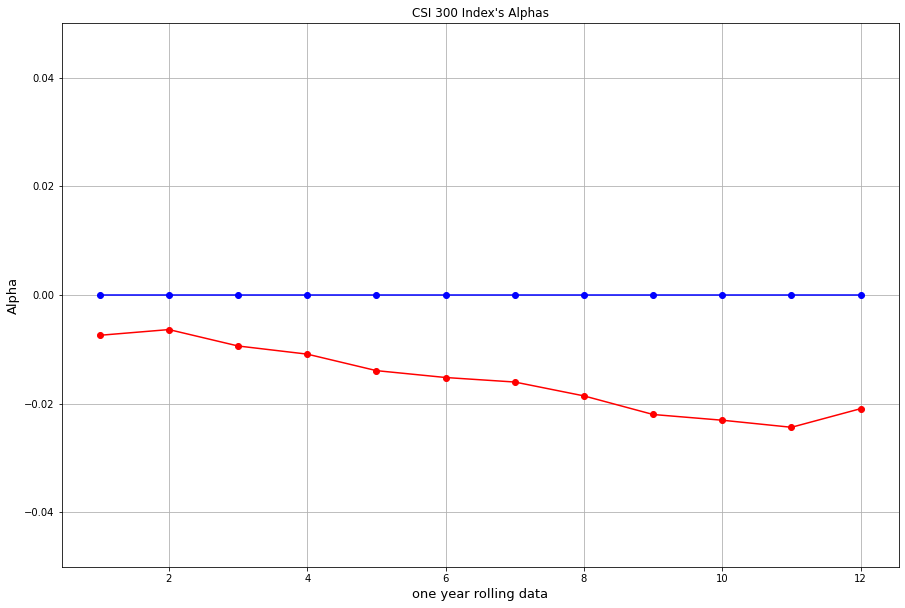

In [167]:
# Plot the rolling alphas (window = 12 months)
plt.figure(figsize = (15, 10))
plt.ylim(-0.05,0.05)
plt.plot(range(1,13), alphas, color='red', marker='o', label = 'unadjusted rolling alpha of CSI 300 Index')
plt.plot(range(1,13),alphas_rolling, color='blue', marker='o', label = 'adjusted rolling alpha of CSI 300 Index')
plt.xlabel(u"one year rolling data",fontsize=13)
plt.ylabel(u"Alpha",rotation=90,fontsize=13)
plt.title(u"CSI 300 Index's Alphas")
plt.grid()
plt.show()